## 1. 시도별 수출현황 분석 (2019.08 ~ 2020.07)

In [48]:
import pandas as pd 

pd.set_option('mode.chained_assignment',  None)

In [49]:
data_input_path = './data_input/'
data_output_path = './data_output/'

df = pd.read_csv(data_input_path + '/inout_0807.csv',skiprows=[0,1,2,3,5])
df.head(5)

,기간,시도명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2019.08,강원도,"4,138","169,239","31,821","355,993","-186,754"
1,2019.08,경기도,"196,484","9,169,822","576,604","10,000,356","-830,534"
2,2019.08,경상남도,"39,920","3,023,712","92,060","1,777,717","1,245,995"
3,2019.08,경상북도,"38,231","3,311,092","58,833","1,332,702","1,978,390"
4,2019.08,광주광역시,"9,581","993,482","40,129","508,339","485,143"


· 문자형 -> 정수형으로 바꾸기 위한 사전 작업 

In [50]:
df['수출건수'] = df['수출건수'].str.replace(',', '')
df['수출금액'] = df['수출금액'].str.replace(',', '')

· 문자형 -> 정수형으로 변환 (to_numeric)

In [51]:
df['수출금액'] = pd.to_numeric(df['수출금액'])
df['수출건수'] = pd.to_numeric(df['수출건수'])

### 1) 코로나 전 (2019.08~2020.01)과 후(2020.02 ~ 2020.07) 데이터 분리 및 전처리

In [52]:
corona_before = [2019.08, 2019.09, 2019.10, 2019.11, 2019.12, 2020.01]

cb_condition = (df.기간.isin(corona_before) == True)
ca_condition = (df.기간.isin(corona_before) == False)
df_2019 = df[cb_condition].reset_index(drop=True)
df_2020 = df[ca_condition].reset_index(drop=True)

del df_2019['수입건수'],df_2019['수입금액'],df_2019['무역수지'],df_2019['기간']
del df_2020['수입건수'],df_2020['수입금액'],df_2020['무역수지'],df_2020['기간']

#### ·지역별로 그룹화하고, 해당 값들에 대한 평균을 구함 

In [53]:
corona_before = df_2019.groupby(df_2019.시도명).mean().round(2).reset_index()
corona_after = df_2020.groupby(df_2020.시도명).mean().round(2).reset_index()

corona_before.head()

,시도명,수출건수,수출금액
0,강원도,3916.33,168814.83
1,경기도,204898.17,9370152.17
2,경상남도,41831.83,3359309.83
3,경상북도,39009.17,3196695.83
4,광주광역시,9727.83,1059661.33


#### · 데이터 저장 (지도 생성에 사용하기 위함)

In [54]:
corona_before.to_csv(data_output_path + 'cb.csv',index=False)
corona_after.to_csv(data_output_path + 'ca.csv',index=False)

In [55]:
corona_before['수출금액 단위조정'] = round(corona_before['수출금액'] / 100000,0).astype(int)
corona_after['수출금액 단위조정'] = round(corona_after['수출금액'] / 100000,0).astype(int)

corona_before = corona_before.sort_values('수출금액', ascending=False).reset_index(drop=True)
corona_after = corona_after.sort_values('수출금액', ascending=False).reset_index(drop=True)

corona_after.head(5)
# corona_before.head()

,시도명,수출건수,수출금액,수출금액 단위조정
0,경기도,187776.17,9222601.67,92
1,충청남도,36575.83,6095978.17,61
2,울산광역시,19476.67,4340764.00,43
3,서울특별시,266129.50,4049922.33,40
4,인천광역시,172578.17,3068107.33,31


#### · 지도 시각화를 위해 위도 경도 정보 병합 

In [56]:
df_ll = pd.read_csv(data_input_path + 'city_ll.csv', header = 0)

df_ll['위도'] = df_ll['위도'].str.replace('N','')
df_ll['경도'] = df_ll['경도'].str.replace('E','')
df_ll['위도'] = df_ll['위도'].str.replace(',','.')
df_ll['경도'] = df_ll['경도'].str.replace(',','.')

corona_before = corona_before.merge(df_ll)
corona_after = corona_after.merge(df_ll)

corona_before.head()

,시도명,수출건수,수출금액,수출금액 단위조정,위도,경도,CTPRVN_CD
0,경기도,204898.17,9370152.17,94,37.41,127.51,41
1,충청남도,36915.17,6850398.33,69,36.51,126.80,44
2,울산광역시,21889.17,5647688.33,56,35.53,129.31,31
3,서울특별시,165795.67,4652330.00,47,37.56,126.97,11
4,경상남도,41831.83,3359309.83,34,35.46,128.21,48


In [57]:
# corona_before.to_csv('corona_before.csv',index=False)
# corona_after.to_csv('corona_after.csv', index=False)

#### 3) 코로나 발생 전, 후 차액을 보여주기 위한 새로운 데이터프레임 생성 

In [58]:
cb = pd.read_csv(data_output_path + 'cb.csv')
ca = pd.read_csv(data_output_path + 'ca.csv')

ca.head(2)

,시도명,수출건수,수출금액
0,강원도,3596.83,157219.50
1,경기도,187776.17,9222601.67


In [59]:
corona_total = cb

corona_total.rename(columns = {'수출건수': '코로나 이전 수출건수'}, inplace=True)
corona_total.rename(columns = {'수출금액': '코로나 이전 수출금액'}, inplace=True)

corona_total['코로나 이후 수출건수'] = ca['수출건수']
corona_total['코로나 이후 수출금액'] = ca['수출금액']
corona_total['차액'] = ca['수출금액'] - cb['코로나 이전 수출금액']

corona_total.to_csv(data_output_path + 'corona_total.csv',index=False)
corona_total.sort_values('차액', ascending=False).reset_index(drop=True).head(5)

,시도명,코로나 이전 수출건수,코로나 이전 수출금액,코로나 이후 수출건수,코로나 이후 수출금액,차액
0,충청북도,22377.33,1838334.67,21176.33,1948220.33,109885.66
1,대전광역시,7424.17,354868.00,7260.33,381039.00,26171.00
2,제주특별자치도,678.50,13662.00,484.00,10991.33,-2670.67
3,광주광역시,9727.83,1059661.33,9248.33,1053836.33,-5825.00
4,강원도,3916.33,168814.83,3596.83,157219.50,-11595.33


#### 4) 지도 제작용 데이터 새성 

In [60]:
city_code = []; city_name = [] 

for i in range(len(df_ll)):
    city_code.append(df_ll['CTPRVN_CD'][i])
    city_name.append(df_ll['시도명'][i])
    
del corona_total['코로나 이전 수출건수'], corona_total['코로나 이전 수출금액'], corona_total['코로나 이후 수출건수'],\
    corona_total['코로나 이후 수출금액']

corona_total['CTPRVN_CD'] = city_code
corona_total.to_csv(data_output_path+'corona_map.csv', index=False)

corona_total.head()

,시도명,차액,CTPRVN_CD
0,강원도,-11595.33,42
1,경기도,-147550.50,41
2,경상남도,-603563.66,48
3,경상북도,-322452.50,47
4,광주광역시,-5825.00,29


## 2. 코로나 전과 후 수출금액 차액이 큰 지역별 수출품목 분석 

### 1) 수출금액 차액이 큰 지역 조회

In [61]:
corona_map = pd.read_csv(data_output_path + 'corona_map.csv')

corona_map.sort_values('차액').head(3).reset_index(drop=True)

,시도명,차액,CTPRVN_CD
0,울산광역시,-1306924.33,31
1,충청남도,-754420.16,44
2,경상남도,-603563.66,48


### 2) 해당 지역 데이터셋 분석 및 전처리 

#### · 조회 대상 도시 정의

In [62]:
city_list = ['ulsan','chungnam','gyeongnam']   # 수출금액 하락 
city_list2 = ['chungbuk','daejun']   # 수출금액 상승 

#### · 데이터 전처리 작업 함수화 

In [63]:
def view_items(city_name):
    city = pd.read_csv(data_input_path + '{}.csv'.format(city_name),skiprows=[0,1,2,3,5])
    
    del city['Unnamed: 5'], city['Unnamed: 4']
    
    city.dropna(inplace=True)
    city.reset_index()

    city['수출품목건수'] = city['수출품목건수'].str.replace(',','').astype(int)
    city['수출금액'] = city['수출금액'].str.replace(',','').astype(int)
    
    corona_before = ['2019.08', '2019.09', '2019.10', '2019.11', '2019.12', '2020.01']

    cb_condition = (city.기간.isin(corona_before) == True)
    ca_condition = (city.기간.isin(corona_before) == False)

    city_before = city[cb_condition].reset_index(drop=True)
    city_after = city[ca_condition].reset_index(drop=True)

    del city_before['기간'], city_after['기간']
    
    idx_num1 = city_before[city_before['성질명'] == '3. 경공업품'].index
    idx_num2 = city_before[city_before['성질명'] == '4. 중화학 공업품'].index
    idx_num3 = city_after[city_after['성질명'] == '3. 경공업품'].index
    idx_num4 = city_after[city_after['성질명'] == '4. 중화학 공업품'].index

    city_before = city_before.drop(idx_num1)
    city_before = city_before.drop(idx_num2)
    city_after = city_after.drop(idx_num3)
    city_after = city_after.drop(idx_num4)
    
    city_before['성질명'] = city_before['성질명'].str.split('.').str[1]
    city_after['성질명'] = city_after['성질명'].str.split('.').str[1]
    
    city_before_total = city_before.groupby('성질명').mean().round(0).astype(int)
    city_after_total = city_after.groupby('성질명').mean().round(0).astype(int)

    city_before_total.reset_index(inplace=True)
    city_after_total.reset_index(inplace=True)

    city_before_total['수출금액_단위'] = (city_before_total['수출금액'] // 1000).astype(str)
    city_after_total['수출금액_단위'] = (city_after_total['수출금액'] // 1000).astype(str)
    
    city_before_total.to_csv(data_output_path + '/cbt.csv',index=False)
    city_after_total.to_csv(data_output_path + './cat.csv',index=False)
    
    cbt = pd.read_csv(data_output_path+'cbt.csv')
    cat = pd.read_csv(data_output_path+'cat.csv')
    
    city_total = cbt 
    
    del city_total['수출금액_단위']
    
    city_total.rename(columns = {'수출품목건수':'이전 수출 건수'}, inplace=True)
    city_total.rename(columns = {'수출금액':'이전 수출 금액'}, inplace=True)
    city_total['이후 수출 건수'] = cat['수출품목건수']
    city_total['이후 수출 금액'] = cat['수출금액']
    city_total['차액'] = cat['수출금액'] - cbt['이전 수출 금액']
    city_total['차액 단위'] = (city_total['차액'] // 1000).astype(str)
    
    for i in range(len(city_total)):
        if city_total['차액 단위'][i] == '0':
            city_total['차액 단위'][i] = '0원'
            continue
        city_total['차액 단위'][i] = city_total['차액 단위'][i] + '백만원'
    
    city_total.to_csv(data_output_path + '{}_total.csv'.format(city_name),index=False) 
    
    return city_total

In [64]:
ulsan_total = view_items('ulsan')
chungnam_total = view_items('chungnam')
gyeongnam_total = view_items('gyeongnam')
chungbuk_total = view_items('chungbuk')
daejun_total = view_items('daejun')

daejun_total

,성질명,이전 수출 건수,이전 수출 금액,이후 수출 건수,이후 수출 금액,차액,차액 단위
0,"가죽, 고무 및 신발류",151,2174,119,1312,-862,-1백만원
1,귀금속 및 보석류,1,560,1,1596,1036,1백만원
2,기 타,773,22866,764,27280,4414,4백만원
3,기계류와 정밀기기,2122,94755,1899,94947,192,0원
4,기타 비금속 광물제품,31,679,26,282,-397,-1백만원
5,기타 섬유제품,98,2267,125,2580,313,0원
6,목제품,27,119,24,146,27,0원
7,섬유사,184,2637,186,2430,-207,-1백만원
8,섬유원료,0,1,0,5,4,0원
9,수송장비,722,51180,545,21597,-29583,-30백만원


## 3. 시도 별 데이터 시각화  

### 1) 한글 폰트 설정, plt 파라미터 설정 

In [65]:
from matplotlib import font_manager, rc 
import platform
import matplotlib.pyplot as plt 

if platform.system() == 'Windows':
    path = 'c:\Windows\Fonts\malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font',faimly='AppleGothic')
else:
    print('Check your OS system')
    
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

### 2) 시각화 대상 데이터셋 조회

In [66]:
ulsan_total.sort_values('차액').head(3)
chungnam_total.sort_values('차액').head(3)
chungbuk_total.sort_values('차액').head(3)
gyeongnam_total.sort_values('차액').head(3)
daejun_total.sort_values('차액').head(3)

,성질명,이전 수출 건수,이전 수출 금액,이후 수출 건수,이후 수출 금액,차액,차액 단위
9,수송장비,722,51180,545,21597,-29583,-30백만원
0,"가죽, 고무 및 신발류",151,2174,119,1312,-862,-1백만원
4,기타 비금속 광물제품,31,679,26,282,-397,-1백만원


### 3) 코로나 발생 전, 후 특정 지역 차액 별 품목 Pie Chart 그리기

In [67]:
city_name = ['ulsan','chungnam','chungbuk','gyeongnam','daejun']

def show_piechart(city_name):
    city = pd.read_csv(data_output_path + '{}_total.csv'.format(city_name))
    minus_sum = 0; plus_sum = 0
    minus_label = []; plus_label = [] 
    
    # 차액이 음수인 것과 양수인 것 분리 
    idx_minus = city[city['차액'] < 0].index
    idx_plus = city[city['차액'] > 0].index
    
    city_minus = city.drop(idx_plus).reset_index(drop=True)
    city_plus = city.drop(idx_minus).reset_index(drop=True)
    
    city_minus['차액'] = city_minus['차액'].abs() 
    
    price_msum = sum(city_minus['차액'])
    price_psum = sum(city_plus['차액']) 
    
    city_minus['차액 비율(%)'] = round(city_minus['차액'] / price_msum * 100, 0).astype(int)
    city_plus['차액 비율(%)'] = round(city_plus['차액'] / price_psum * 100, 0).astype(int)
    
    city_minus = city_minus.sort_values('차액 비율(%)', ascending=False)
    city_plus = city_plus.sort_values('차액 비율(%)', ascending=False)
    
    idx_zero = city_minus[city_minus['차액 비율(%)'] == 0].index
    idx_zero2 = city_plus[city_plus['차액 비율(%)'] == 0].index
    
    city_minus = city_minus.drop(idx_zero).reset_index(drop=True)
    city_plus = city_plus.drop(idx_zero2).reset_index(drop=True)
    
    minus_ratio = city_minus['차액 비율(%)'].tolist()
    plus_ratio = city_plus['차액 비율(%)'].tolist()
    
    minus_label = city_minus['성질명']
    plus_label = city_plus['성질명']
    
    fig, axarr = plt.subplots(1, 2)
    ax1 = axarr[0]; ax2 = axarr[1]
    
    ax1.pie(minus_ratio, shadow=True, autopct='%1.1f%%')
    ax1.axis('equal')
    ax1.set_title('수출 차액 (손실)',fontsize=16, fontweight='bold')
    
    ax2.pie(plus_ratio, shadow=True, autopct='%1.1f%%')
    ax2.axis('equal')
    ax2.set_title('수출 차액 (이득)',fontsize=16, fontweight='bold')
    
    lgd1 = ax1.legend(minus_label, loc='best')
    lgd2 = ax2.legend(plus_label, loc='best')
    
    fig.suptitle('코로나 발생 전후 시도별 수출 차액 ({})'.format(city_name),fontsize=20,fontweight='bold')
    
    return city

,성질명,이전 수출 건수,이전 수출 금액,이후 수출 건수,이후 수출 금액,차액,차액 단위
0,"가죽, 고무 및 신발류",905,4633,1059,2971,-1662,-2백만원
1,귀금속 및 보석류,14,4780,14,9630,4850,4백만원
2,기 타,2963,47999,3214,45583,-2416,-3백만원
3,기계류와 정밀기기,7846,381394,7390,339910,-41484,-42백만원
4,기타 비금속 광물제품,603,79575,625,82212,2637,2백만원


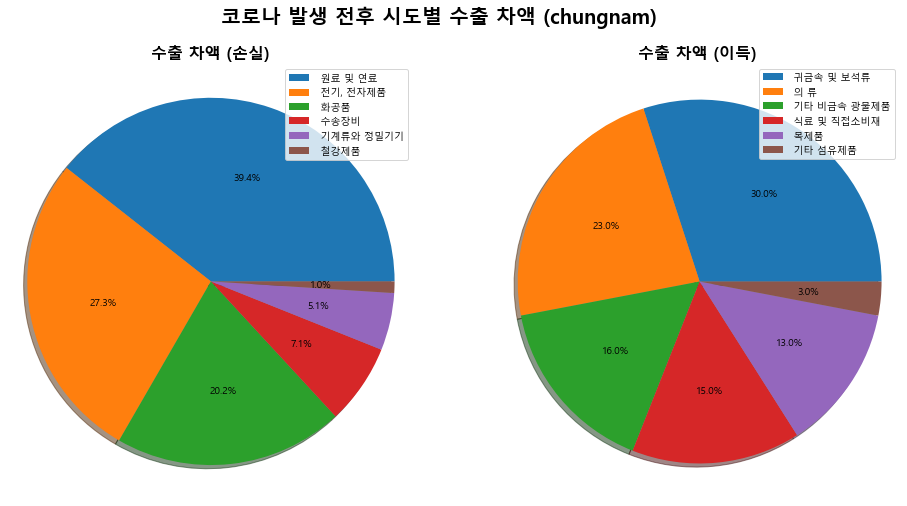

In [68]:
city = show_piechart('chungnam')
city.head(5)

### 4) 지역별 수출금액 변화 추이 시각화 (2019.08 ~ 2020.07)

In [69]:
def line_graph(city_name):
    city = pd.read_csv(data_input_path + '{}.csv'.format(city_name),skiprows=[0,1,2,3,5])
    
    del city['Unnamed: 5'], city['Unnamed: 4']
    city.dropna(inplace=True)
    city.reset_index()

    city['수출품목건수'] = city['수출품목건수'].str.replace(',','').astype(int)
    city['수출금액'] = city['수출금액'].str.replace(',','').astype(int)
    
    idx_num1 = city[city['성질명'] == '3. 경공업품'].index
    idx_num2 = city[city['성질명'] == '4. 중화학 공업품'].index
    
    city = city.drop(idx_num1)
    city = city.drop(idx_num2)
    
    del city['성질명']
    
    city = city.groupby('기간').mean().round(0).astype(int)
    city.reset_index(inplace=True)
    
    city['수출금액_단위'] = (city['수출금액'] // 1000).astype(int)

    plt.plot(city['기간'],city['수출금액'])
    plt.legend(['수출금액_단위(1,000 USD)'],fontsize=16)
    plt.title('시도별 2019.08 ~ 2020.07 수출금액 변동 ({})'.format(city_name), fontsize=20)
    plt.show()
    
    return city 

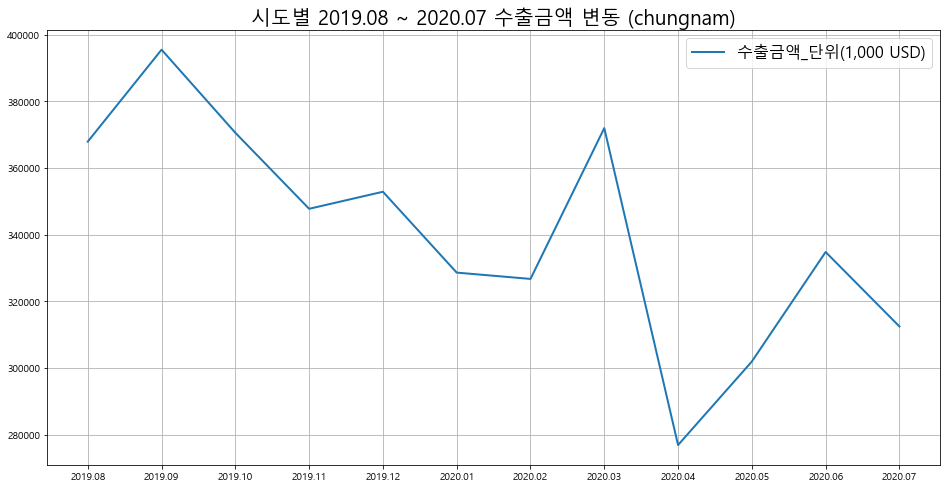

,기간,수출품목건수,수출금액,수출금액_단위
7,2020.03,2871,371965,371
8,2020.04,2528,276971,276
9,2020.05,2393,302005,302
10,2020.06,2496,334829,334
11,2020.07,2795,312515,312


In [70]:
city = line_graph('chungnam') 
city.tail()

### 울산 수출금액 하락 관련 뉴스 기사 조사 (2020.07.28)

한국무역협회 울산본부(본부장 김정철)가 발표한 ‘2020 상반기 울산 수출입동향’에 따르면, 상반기 울산 수출은 작년 동기대비 23.5% 
감소한 269억7900만 달러를 기록했다. 이는 2006년 상반기 이후 14년 만에 최저기록이다.

전국 17개 광역지자체 중 최대 수출 감소폭이다. 같은기간 국내 수출은 전년 동기 대비 11.3% 감소하는데 그쳤다.

품목별로는 울산의 최대 수출품목인 석유제품의 수출은 전년 동기 대비 39.4% 감소한 56억9700만 달러를 기록했다. 

코로나 확산에 따른 글로벌 석유수요 감소의 영향이 4월부터 본격 반영돼 국제유가(-37.9%) 및 수출단가(-33.8%)가 급락했고, 수출물량도 감소(-8.2%)했다. 석유화학제품도 전년 상반기 대비 23% 감소한 34억1000만 달러로 상반기 기준 2004년 이후 16년만에 최저치로 주저앉았다.

수출물량 증가(5.3%)에도 불구하고 글로벌 공급과잉 확대, 국제유가 급락 등의 영향으로 수출단가가 크게 하락(-26.8%)해 수출액이 줄었다.

자동차 수출은 최대 수출시장인 북미지역에서의 재고물량 증가 및 판매감소, 국내 생산 공장의 휴업 등의 영향으로 19.5% 감소한 68억9900만 달러를 기록했다. 다만, 전기자동차 수출은 유럽에서의 판매 호조에 힘입어 큰 폭으로 증가(9억4800만 달러, 39.7%)했다.

출처 : 경상일보(http://www.ksilbo.co.kr)

#### 참고
1. https://zero-coding.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-Pandas-Matplotlib-%EA%B7%B8%EB%9E%98%ED%94%84line-b-ar-%EA%B7%B8%EB%A6%AC%EA%B8%B001
2. https://eunsukimme.github.io/data%20visualization/2019/10/14/Matplotlib-line-graph/

## 4. 지역별 데이터 차액 시각화 (choropleth) 

### 1) 라이브러리 import 

In [71]:
import pandas as pd 
import folium
import json
import os 
import plotly.express as px

### 2) geojson 데이터 import 

In [72]:
korea_province_path = data_input_path + 'TL_SCCO_CTPRVN_WGS84.json'   
korea_province_geo = json.load(open(korea_province_path, encoding='utf-8'))   # 인코딩 지정 필수 
korea_province_geo['features'][0]['properties']

{'CTPRVN_CD': '42', 'CTP_ENG_NM': 'Gangwon-do', 'CTP_KOR_NM': '강원도'}

### 3) 데이터 전처리

corona_map['마이너스차액'][i] = 0을 수행할 경우 setting with copy warning이 발생하는데, copy() 메서드를 이용하면 해결할 수 있음 

참고: https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221817400937

In [73]:
corona_map = pd.read_csv(data_output_path + 'corona_map.csv',header=0)
corona_map.head(2)

corona_map['차액'] = corona_map['차액'].round(0).astype(int)   # 문자형 -> 정수형 
corona_map['차액변환'] = (corona_map['차액'] / 1000).round(0).astype(int)

# 코드가 숫자로 인식될 경우 오류가 발생 -> 문자형으로 바꿔줘야 함 !! 
corona_map['CTPRVN_CD'] = corona_map['CTPRVN_CD'].astype(str)

price_val = corona_map['차액'].tolist()

corona_map['마이너스차액'] = price_val
corona_map['플러스차액'] = price_val

for i in range(len(corona_map)): 
    if corona_map['마이너스차액'][i] > 0: 
        corona_map['마이너스차액'][i] = 0 
    elif corona_map['플러스차액'][i] < 0:
        corona_map['플러스차액'][i] = 0

corona_map['CTPRVN_CD'] = corona_map['CTPRVN_CD'].astype(str)
# corona_map.sort_values('차액',ascending=False).head(3).reset_index(drop=True)
corona_map

,시도명,차액,CTPRVN_CD,차액변환,마이너스차액,플러스차액
0,강원도,-11595,42,-12,-11595,0
1,경기도,-147550,41,-148,-147550,0
2,경상남도,-603564,48,-604,-603564,0
3,경상북도,-322452,47,-322,-322452,0
4,광주광역시,-5825,29,-6,-5825,0
5,대구광역시,-122555,27,-123,-122555,0
6,대전광역시,26171,30,26,0,26171
7,부산광역시,-206548,26,-207,-206548,0
8,서울특별시,-602408,11,-602,-602408,0
9,세종특별자치시,-12334,36,-12,-12334,0


In [74]:
corona_tmp = pd.read_csv(data_output_path + './corona_tmp.csv')

corona_tmp['마이너스차액'] = corona_map['차액']
corona_tmp['플러스차액'] = corona_map['차액']

for i in range(len(corona_tmp)): 
    if corona_tmp['마이너스차액'][i] > 0: 
        corona_tmp['마이너스차액'][i] = 0 
    elif corona_tmp['플러스차액'][i] < 0:
        corona_tmp['플러스차액'][i] = 0

corona_tmp['CTPRVN_CD'] = corona_tmp['CTPRVN_CD'].astype(str)
corona_tmp.head(2)

,시도명,차액,CTPRVN_CD,차액변환,마이너스차액,플러스차액
0,강원도,-11595,42,-12,-11595,0
1,경기도,-147550,41,-148,-147550,0


### 4) 코로나발생 전·후 수출금액 차액 비교 (손실 지역) 

#### · tiles = OpenStreetMap, CartoDB dark_matter, Stamen Toner
#### · fill_color = YlGn, BuPu 

In [75]:
minus_m = folium.Map(location=[36,128],tiles='OpenStreetMap', zoom_start=7)

tmp = folium.Choropleth(
    geo_data=korea_province_geo,
    data = corona_map,
    columns = ('CTPRVN_CD','마이너스차액'),
    key_on = 'feature.properties.CTPRVN_CD',
    fill_color='YlGn', 
    fill_opacity=0.6,
    line_opacity=0.5,
    highlight = True,
    legend_name='코로나로 인한 수출 차액',
).add_to(minus_m)

# 색칠한 Layer 켜고 끄기 버튼 추가 
folium.LayerControl(collapsed=True).add_to(minus_m)

# label 추가하기 
tmp.geojson.add_child(
    folium.features.GeoJsonTooltip(['CTP_KOR_NM'], labels=False)
)

minus_m.save(data_output_path + 'minus_map.html')
minus_m

### 5) 코로나발생 전·후 수출금액 차액 비교 (이득 지역) 

In [76]:
plus_m = folium.Map(location=[36,128],tiles='OpenStreetMap', zoom_start=7)

tmp = folium.Choropleth(
    geo_data=korea_province_geo,
    data = corona_map,
    columns = ('CTPRVN_CD','플러스차액'),
    key_on = 'feature.properties.CTPRVN_CD',
    fill_color='YlGn',
    fill_opacity=0.6,
    line_opacity=0.5,
    highlight = True,
    legend_name='코로나로 인한 수출 차액',
).add_to(plus_m)

folium.LayerControl(collapsed=True).add_to(plus_m)

tmp.geojson.add_child(
    folium.features.GeoJsonTooltip(['CTP_KOR_NM'], labels=False)
)

plus_m.save(data_output_path + 'plus_map.html')
plus_m

In [87]:
corona_before['CTPRVN_CD'] = corona_before['CTPRVN_CD'].astype(str)
corona_after['CTPRVN_CD'] = corona_after['CTPRVN_CD'].astype(str)
corona_before.head(2)

,시도명,수출건수,수출금액,수출금액 단위조정,위도,경도,CTPRVN_CD
0,경기도,204898.17,9370152.17,94,37.41,127.51,41
1,충청남도,36915.17,6850398.33,69,36.51,126.80,44


### 6) 코로나 발생 이전 시도별 수출금액 시각화 

In [79]:
south_Kor = [36, 128]
map_Kor = folium.Map(location=south_Kor, zoom_start = 7)

for i in range(len(corona_before)):
    name = corona_before['시도명'][i]
    count = corona_before['수출금액'][i]
    size = int(count) / 500000
    long = float(corona_before['위도'][i])
    lat = float(corona_before['경도'][i])
    folium.CircleMarker((long, lat), radius = size, color='red', popup=[name, count]).add_to(map_Kor)

map_Kor

In [91]:
before_corona = folium.Map(location=[36,128], tiles='OpenstreetMap',zoom_start=7)

tmp = folium.Choropleth(
    geo_data=korea_province_geo,
    data = corona_before,
    columns = ('CTPRVN_CD','수출금액 단위조정'),
    key_on = 'feature.properties.CTPRVN_CD',
    fill_color='YlGn', 
    fill_opacity=0.6,
    line_opacity=0.5,
    highlight = True,
    legend_name='코로나 이전 시·도 별 수출금액',
).add_to(before_corona)

# 색칠한 Layer 켜고 끄기 버튼 추가 
folium.LayerControl(collapsed=True).add_to(before_corona)

# label 추가하기 
tmp.geojson.add_child(
    folium.features.GeoJsonTooltip(['CTP_KOR_NM'], labels=False)
)

before_corona.save(data_output_path + 'before_corona.html')
before_corona

#### folium, choropleth 출처
https://www.nagarajbhat.com/post/folium-visualization/ -> 향후 추가 응용할 때 참고 가능
https://mjs1995.tistory.com/182
https://blog.naver.com/PostView.nhn?blogId=kcchang61&logNo=221350672356
https://anweh.tistory.com/55

### 7) 코로나 발생 이후 시·도 별 수출금액 시각화 

In [80]:
for i in range(len(corona_after)):
    name = corona_after['시도명'][i]
    count = corona_after['수출금액'][i]
    size = int(count) / 500000
    long = float(corona_after['위도'][i])
    lat = float(corona_after['경도'][i])
    folium.CircleMarker((long, lat), radius = size, color='red', popup=[name,count]).add_to(map_Kor)

map_Kor

In [92]:
after_corona = folium.Map(location=[36,128], tiles='OpenstreetMap',zoom_start=7)

tmp = folium.Choropleth(
    geo_data=korea_province_geo,
    data = corona_after,
    columns = ('CTPRVN_CD','수출금액 단위조정'),
    key_on = 'feature.properties.CTPRVN_CD',
    fill_color='YlGn', 
    fill_opacity=0.6,
    line_opacity=0.5,
    highlight = True,
    legend_name='코로나로 이후 시·도 별 수출금액',
).add_to(after_corona)

# 색칠한 Layer 켜고 끄기 버튼 추가 
folium.LayerControl(collapsed=True).add_to(after_corona)

# label 추가하기 
tmp.geojson.add_child(
    folium.features.GeoJsonTooltip(['CTP_KOR_NM'], labels=False)
)

after_corona.save(data_output_path + 'after_corona.html')
after_corona

## 5. GUI 프로그래밍

In [94]:
from tkinter import *

def click_city_button():
    city_window = Tk() # 새 창
    city_window.title("City")
    city_window.geometry("300x100")
    city_label= Label(city_window, text = "시도별 수출입실적")
    city_label.pack()
    listbox = Listbox(city_window, width = 50, height=0)
    listbox.insert(0, '시도별 코로나 전, 후 수출 차액') 
    listbox.insert(1, '코로나 발생 전, 후 시도별 수출금액 시각화')
    
    def click_listbox(event):
        select = event.widget.curselection()
        if select[0] == 0: 
            click_num1()  # 시도별 코로나 - 
        elif select[0] == 1: 
            click_num2()  # 시도별 코로나 발생 - 
       
    listbox.bind('<<ListboxSelect>>',click_listbox) # add
    listbox.pack()
    city_window.mainloop()

def click_num1():
    num1_window = Tk()
    num1_window.title('choropleth map')
    num1_window.geometry('600x600')
    num1_label = Label(num1_window, text='시도별 코로나 전, 후 수출 차액')
    num1_label.pack()
    photo = PhotoImage(file = data_input_path + 'corona_map_DataFrame.PNG', master = num1_window)
    num1_label.config(image=photo)
    minus_button = Button(num1_window, text = '손실 지역 조회', command=click_num1_0)
    minus_button.place(x=200, y=570)
    plus_button = Button(num1_window, text = '이득 지역 조회', command=click_num1_1)
    plus_button.place(x=300, y=570)
    num1_window.mainloop()

def click_num1_0():
    num1_0_window = Tk()
    num1_0_window.title('수출 차액 (마이너스)')
    num1_0_window.geometry('900x700')
    num1_0_label = Label(num1_0_window, text='코로나 전, 후 수출 차액 (마이너스)')
    num1_0_label.pack()
    photo = PhotoImage(file = data_input_path + 'price_minus.PNG',master=num1_0_window)
    num1_0_label.config(image=photo)
    num1_0_window.mainloop()
    
def click_num1_1():
    num1_1_window = Tk()
    num1_1_window.title('수출 차액 (플러스)')
    num1_1_window.geometry('900x700')
    num1_1_label = Label(num1_1_window, text='코로나 전, 후 수출 차액 (플러스)')
    num1_1_label.pack()
    photo = PhotoImage(file = data_input_path + 'price_plus.PNG',master=num1_1_window)
    num1_1_label.config(image=photo)
    num1_1_window.mainloop()

def click_num2():
    num2_window = Tk() 
    num2_window.title('수출입 실적')
    num2_window.geometry("600x550")
    num2_label = Label(num2_window, text='시·도 별 수출입 실적')
    num2_label.pack()
    photo = PhotoImage(file=data_input_path + 'regions_export_price.PNG', master=num2_window)
    num2_label.config(image=photo)
    ulsan_button = Button(num2_window, text='울산광역시', command=click_num2_1)
    ulsan_button.place(x= 200, y = 515)
    chungnam_button = Button(num2_window, text='충청남도', command=click_num2_2)
    chungnam_button.place(x = 300, y=515)
    chungbuk_button = Button(num2_window, text='충청북도', command=click_num2_3)
    chungbuk_button.place(x= 400, y=515)
    
    num2_window.mainloop()
    
def click_num2_1():
    num2_1_window = Tk()
    num2_1_window.title('울산광역시')
    num2_1_label = Label(num2_1_window, text='울산광역시 수출입 실적')
    num2_1_label.pack()
    photo = PhotoImage(file = data_input_path + 'ulsan_total.PNG',master=num2_1_window)
    ulsan_button = Button(num2_1_window, image=photo,command=click_ulsan_export)
    ulsan_button.pack()
    num2_1_window.mainloop()

def click_ulsan_export():
    ulsan_window = Tk()
    ulsan_window.title('울산광역시')
    ulsan_label = Label(ulsan_window, text='울산광역시 기간별 수출금액 조회')
    ulsan_label.pack()
    photo = PhotoImage(file=data_input_path + 'ulsan_date_total.png', master=ulsan_window)
    ulsan_label.config(image=photo)
    ulsan_window.mainloop()

def click_num2_2():
    num2_2_window = Tk()
    num2_2_window.title('충청남도')
    num2_2_label = Label(num2_2_window, text='충청남도 수출입 실적')
    num2_2_label.pack()
    photo = PhotoImage(file = data_input_path + 'chungnam_total.png',master=num2_2_window)
    ulsan_button = Button(num2_2_window, image=photo,command=click_chungnam_export)
    ulsan_button.pack()
    num2_2_window.mainloop()

def click_chungnam_export():
    chungnam_window = Tk()
    chungnam_window.title('충청남도')
    chungnam_label = Label(chungnam_window, text='충청남도 기간별 수출금액 조회')
    chungnam_label.pack()
    photo = PhotoImage(file=data_input_path + 'chungnam_date_total.png', master=chungnam_window)
    chungnam_label.config(image=photo)
    chungnam_window.mainloop()
    
def click_num2_3():
    num2_3_window = Tk()
    num2_3_window.title('충청북도')
    num2_3_label = Label(num2_3_window, text='충청북도 수출입 실적')
    num2_3_label.pack()
    photo = PhotoImage(file = data_input_path + 'chungbuk_total.png',master=num2_3_window)
    chungbuk_button = Button(num2_3_window, image=photo,command=click_chungbuk_export)
    chungbuk_button.pack()
    num2_3_window.mainloop()

def click_chungbuk_export():
    chungbuk_window = Tk()
    chungbuk_window.title('충청북도')
    chungbuk_label = Label(chungbuk_window, text='충청북도 기간별 수출금액 조회')
    chungbuk_label.pack()
    photo = PhotoImage(file=data_input_path + 'chungbuk_date_total.png', master=chungbuk_window)
    chungbuk_label.config(image=photo)
    chungbuk_window.mainloop() 

    
window = Tk()
window.title("Team 3")
window.geometry("300x150") # 가로 * 세로
label = Label(window, text = "Mini Project #2")
label.pack()
cityButton = Button(window, text="시도별 수출입실적", command=click_city_button)
cityButton.pack()
window.mainloop()